https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [1]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def draw_sample(image, mask, classes, is_tensor=False):

    gray_mask = []
    if is_tensor:
        mask = mask.permute(1, 2, 0)
        image = image.permute(1, 2, 0)

    for line in mask:
        for pix in line:
            gray_mask.append(classes[np.argmax(pix)])

    gray_mask = np.reshape(gray_mask, (mask.shape[0], mask.shape[1]))

    # print("classes: {}".format(np.unique(gray_mask)))

    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image")

    plt.subplot(1, 2, 2)
    plt.imshow(gray_mask, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Mask")

In [3]:
ROOT = Path("headsegmentationdataset/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"

In [4]:
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

In [5]:
from typing import List
from catalyst import utils

from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(
        self,
        classes,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms
        self.n_classes = len(classes)
        self.classes = classes

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        result = {"image": image}

        if self.masks is not None:
            mask = cv2.imread(str(self.masks[idx]),0)
            one_hot = np.zeros((mask.shape[0], mask.shape[1], self.n_classes))
            for i, unique_value in enumerate(self.classes):
                one_hot[:, :, i][mask == unique_value] = 1
            result["mask"] = one_hot

        if self.transforms is not None:
            result = self.transforms(**result)

        result["filename"] = image_path.name

        return result

/home/kuskov/anaconda3/envs/cv_dl_tasks/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


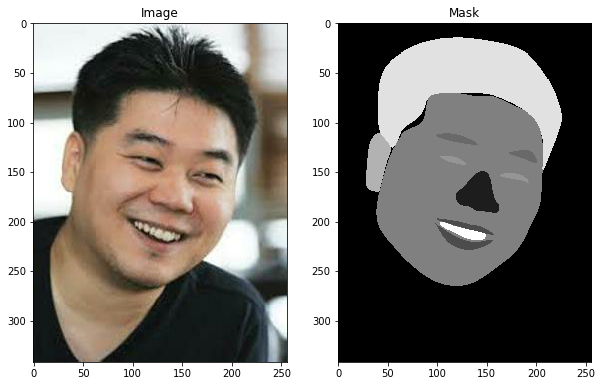

In [6]:
CLASSES = [0, 29, 76, 105, 128, 149, 178, 225, 255]
dataset = SegmentationDataset(CLASSES, ALL_IMAGES, ALL_MASKS)
#
sample = dataset[0]
draw_sample(sample["image"], sample["mask"], CLASSES)
# print(sample["image"], sample["mask"].shape)

In [7]:
import albumentations as albu
from albumentations.pytorch import ToTensor, ToTensorV2

In [8]:
def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]

def post_transforms():
    return [albu.Normalize(), ToTensor(num_classes=9)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [9]:
train_transforms = compose([
    pre_transforms(),
    hard_transforms(),
    post_transforms(),
])
valid_transforms = compose([pre_transforms(), post_transforms()])
visualize_transforms = compose([pre_transforms(), hard_transforms()])

In [10]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And expect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [11]:
batch_size = 16
random_state = 16

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=random_state,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

In [12]:
dataloader_iterator = iter(loaders["train"])
a = next(dataloader_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


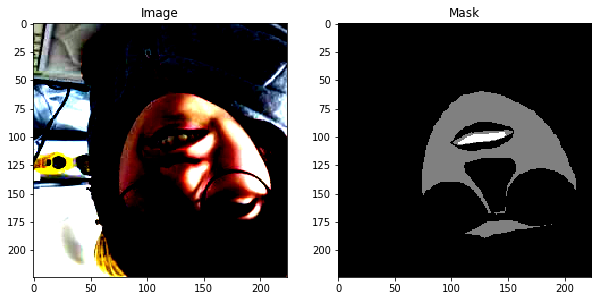

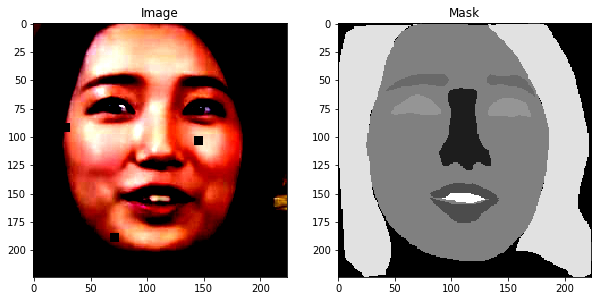

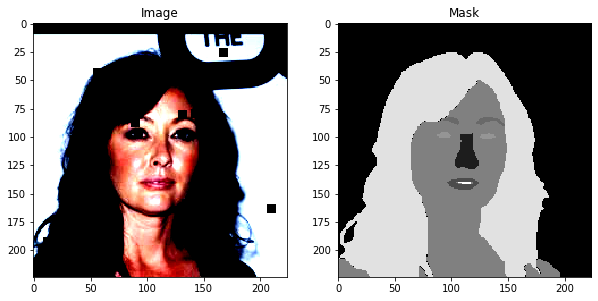

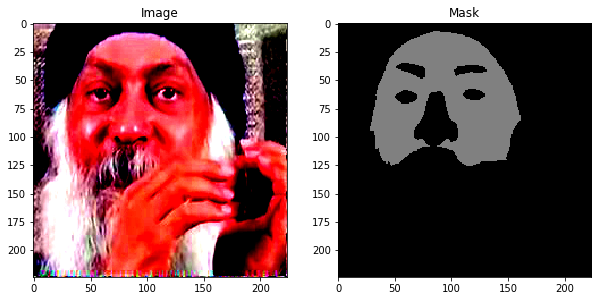

In [13]:
for i in range (min(len(a["image"])-1, 4)):
    draw_sample(a["image"][i], a["mask"][i], CLASSES, is_tensor=True)

In [14]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
# model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)
# aux_params = dict(pooling = 'avg',
#                   dropout = 0.5,
#                   activation = 'softmax2d',
#                   classes = 9
#                   )
aux_params= None
model = smp.Unet(encoder_name="mobilenet_v2", classes=9, aux_params=aux_params)
# model = smp.Unet(encoder_name='inceptionv4', classes=9)

In [15]:
# from torchsummary import summary
# summary(model, (3, 224, 224))

In [16]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [17]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.001

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [18]:
from catalyst.dl import SupervisedRunner

num_epochs = 10
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

# if is_fp16_used:
#     fp16_params = dict(opt_level="O1") # params for FP16
# else:
#     fp16_params = None

# print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


In [19]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [20]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=None,
    # prints train logs
    verbose=True,
)

1/10 * Epoch (train): 100% 330/330 [01:29<00:00,  3.70it/s, dice=0.734, iou=0.580, loss=0.773, loss_bce=0.109, loss_dice=0.266, loss_iou=0.420]
1/10 * Epoch (valid): 100% 82/82 [00:10<00:00,  8.20it/s, dice=0.722, iou=0.565, loss=0.810, loss_bce=0.121, loss_dice=0.278, loss_iou=0.435]
[2020-09-06 13:16:02,690] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): dice=0.4188 | iou=0.2796 | loss=1.5959 | loss_bce=0.3679 | loss_dice=0.5812 | loss_iou=0.7204
1/10 * Epoch 1 (valid): dice=0.7219 | iou=0.5651 | loss=0.8087 | loss_bce=0.1196 | loss_dice=0.2781 | loss_iou=0.4349
2/10 * Epoch (train): 100% 330/330 [01:29<00:00,  3.68it/s, dice=0.840, iou=0.724, loss=0.523, loss_bce=0.110, loss_dice=0.160, loss_iou=0.276]
2/10 * Epoch (valid): 100% 82/82 [00:09<00:00,  8.71it/s, dice=0.856, iou=0.748, loss=0.466, loss_bce=0.088, loss_dice=0.144, loss_iou=0.252]
[2020-09-06 13:17:42,302] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): dice=0.808

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



In [21]:
# ls -lh ./logs/segmentation/checkpoints/

SyntaxError: invalid syntax (<ipython-input-21-09d475dc9396>, line 1)

In [22]:
from pathlib import Path
ROOT = Path("headsegmentationdataset/")
test_image_path = ROOT / "test"
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

In [23]:
# create test dataset
test_dataset = SegmentationDataset(
    CLASSES,
    TEST_IMAGES,
    transforms=valid_transforms
)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(),
    runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth")
    # runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/train.1.exception_KeyboardInterrupt.pth")
)))

print(type(predictions))
print(predictions.shape)

<class 'numpy.ndarray'>
(14, 9, 224, 224)


{'image': tensor([[[-0.6794, -0.6794, -0.6452,  ..., -0.9020, -0.8849, -0.8849],
         [-0.6452, -0.6452, -0.6109,  ..., -0.9020, -0.8849, -0.8849],
         [-0.6452, -0.6452, -0.6452,  ..., -0.8849, -0.8849, -0.8849],
         ...,
         [ 0.3652,  0.3823,  0.1939,  ..., -0.7822, -0.7822, -0.8335],
         [ 0.3138,  0.5193,  0.1597,  ..., -0.7993, -0.8335, -0.8335],
         [ 0.4679,  0.2796,  0.0912,  ..., -0.8335, -0.8678, -0.8678]],

        [[-1.3354, -1.3354, -1.3004,  ..., -1.3880, -1.3704, -1.3704],
         [-1.3004, -1.3004, -1.2654,  ..., -1.3880, -1.3704, -1.3704],
         [-1.3004, -1.3004, -1.3004,  ..., -1.3704, -1.3704, -1.3704],
         ...,
         [-0.6001, -0.6702, -0.7227,  ..., -1.0903, -1.0903, -1.1429],
         [-0.5126, -0.4251, -0.7752,  ..., -1.0728, -1.1078, -1.1078],
         [-0.2500, -0.6176, -0.8452,  ..., -1.0728, -1.1078, -1.1078]],

        [[-1.2641, -1.2641, -1.2293,  ..., -1.3164, -1.2990, -1.2990],
         [-1.2293, -1.2293, -1.1944

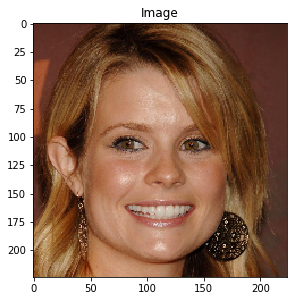

In [40]:
# p = predictions[0].permute(1, 2, 0)
# print (p.shape)
import torch
threshold = 0.5
max_count = 0
#
# masks = []
for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    # print(features["image"])
#     image = utils.tensor_to_ndimage(features["image"])
#
    # print(logits)
    m = torch.from_numpy(logits[0]).sigmoid()
    # print(max(m[0]))
    # print(min(m[0]))
    print(max(m.shape))
    # m = torch.from_numpy(logits)
    # m.sigmoid()
    # print(m)
    # m2 = m.sigmoid()

    # print(m.shape)
    # mask_ = torch.from_numpy(logits[0]).sigmoid()
    # mask = utils.detach(mask_ > threshold).astype("float")

    # print(mask.shape)
    # draw_sample(image, mask, CLASSES,is_tensor=True)
    # show_examples(name="", image=image, mask=mask)

    # image is ok
    image = utils.tensor_to_ndimage(features["image"])
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image")



    if i >= max_count:
        break
plt.show()